In [1]:
using Plots

In [2]:
using LinearAlgebra

In [3]:
function v(x; m=1, ω=1)
    return 0.5 * m * ω * x^2
end

v (generic function with 1 method)

In [6]:
function p(x, E; m=1, ω=1, ħ=1)
    return -2m / ħ^2 * (v(x; m, ω) - E)
end

p (generic function with 1 method)

In [12]:
function numerov_iteration(x, Δ, yj, yi, E; dir=1)
    yk = 2yj*(1 - (5Δ^2 / 12) * p(x, E))
    yk -= yi*(1 + (Δ^2 / 12) * p(x- dir*Δ, E))
    yk /= (1 + (Δ^2 / 12) * p(x + dir*Δ, E))
    return yk
end

numerov_iteration (generic function with 3 methods)

In [20]:
function match_wavefn!(
        ψ, E_n, x, Δ, n_match;
        m=1.0, ħ=1.0, s=1e-10
    )
    Nx = length(x)
    ψ[2] = ψ[end - 1] = s
    for i =  2:n_match - 1
        ψ[i+1] = numerov_iteration(x[i], Δ, ψ[i], ψ[i-1], E_n)
    end

    for i = Nx - 1:-1:n_match + 2
        ψ[i-1] = numerov_iteration(x[i], Δ, ψ[i], ψ[i+1], E_n; dir=-1)
    end

    # Scale the right part equal to left part
    ψ_left = ψ[n_match]
    ψ_right = numerov_iteration(
        x[n_match+1], Δ, 
        ψ[n_match+1], ψ[n_match+2], E; dir=-1
    )
    ψ[n_match+1:end] = (ψ_left / ψ_right) * ψ[n_match+1:end]
    return normalize!(ψ)
end

match_wavefn! (generic function with 1 method)

In [47]:
Δ = 0.001
x = collect(-10:Δ:10)
ψ = zeros(Float64, length(x))
E = 9.513

x_match = 2
n_match = 0
for i = 1:length(x)
    (x[i] <= x_match) ? continue : ((n_match = i); break)
end
match_wavefn!(ψ, E, x, Δ, n_match)

20001-element Vector{Float64}:
  0.0
  2.6402481886463758e-18
  5.280710108589259e-18
  7.921599411628067e-18
  1.0563129678554807e-17
  1.3205514436421796e-17
  1.5848967175787994e-17
  1.8493701367945286e-17
  2.1139930482126172e-17
  2.378786800269424e-17
  2.6437727446318783e-17
  2.908972237913502e-17
  3.174406643389122e-17
  ⋮
 -2.834496442094207e-17
 -2.576086612548663e-17
 -2.3178848646216747e-17
 -2.0598703884738574e-17
 -1.8020223790857782e-17
 -1.544320034585863e-17
 -1.286742554576909e-17
 -1.0292691384610466e-17
 -7.718789837630271e-18
 -5.14551284451696e-18
 -2.5726522925951547e-18
 -0.0

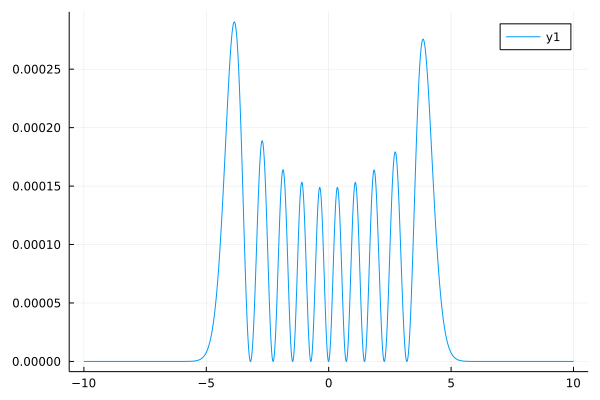

In [49]:
plot(x, abs2.(ψ))

In [41]:
function cooley_correction!(x, Δ, ψ, n_match, p, v, E; ħ=1, m=1, ω=1)
    ΔE  = (1 + (Δ^2 / 12) * p(x[n_match] + Δ, E)) * ψ[n_match + 1]  # Y_{m+1}
    ΔE += (1 + (Δ^2 / 12) * p(x[n_match] - Δ, E)) * ψ[n_match - 1]  # Y_{m-1}
    ΔE -= 2*(1 + (Δ^2 / 12) * p(x[n_match], E)) * ψ[n_match]  # 2*Y_{m}
    ΔE *= (-ħ^2 / (2*m*Δ^2))
    ΔE += ( v(x[n_match]) - E ) * ψ[n_match]
    ΔE *= conj(ψ[n_match]) / sum(abs2.(ψ))
    return ΔE
end

cooley_correction! (generic function with 1 method)

In [37]:
? conj

search: conj conj! cond const convert contour continue contains contourf



```
conj(z)
```

Compute the complex conjugate of a complex number `z`.

# Examples

```jldoctest
julia> conj(1 + 3im)
1 - 3im
```


In [48]:
test = cooley_correction!(x, Δ, ψ, n_match, p, v, E)

-0.012879957915510618

In [56]:
function find_eigenstate(
        x_min::Float64, 
        x_max::Float64, 
        x_match::Float64, 
        V_x::Function, 
        E_min::Float64, 
        E_max::Float64;
        Δ=0.001, m=1.0, ħ=1.0,
        s=1e-10, err=1e-6,
        kwargs...
    )
    x = collect(x_min:Δ:x_max)
    Nx = length(x)
    n_match = 0
    for i = 1:Nx
        (x[i] <= x_match) ? continue : ((n_match = i); break)
    end
    
    # Define P(x) for numerov method
    P(x, E; kwargs...) = -2m / ħ^2 * (v(x; kwargs...) - E)

    # Array to store wavefunction
    ψ = zeros(Float64, length(x))
    
    # Initial Guess for Energy
    E = 0.5*(E_max + E_min)
    match_wavefn!(ψ, E, x, Δ, n_match)
    ΔE = cooley_correction!(x, Δ, ψ, n_match, P, V_x, E)

    while(ΔE >= err)
        E += ΔE
        match_wavefn!(ψ, E, x, Δ, n_match)
        ΔE = cooley_correction!(x, Δ, ψ, n_match, P, V_x, E)
    end
    
    E_converged = E + ΔE
    match_wavefn!(ψ, E, x, Δ, n_match)
    return E_converged, ψ
end

find_eigenstate (generic function with 1 method)

In [63]:
x_min = -10.0
x_max = 10.0
x_match = 2.0
E_min = 13.0
E_max = 14.0
E, ψ = find_eigenstate(x_min, x_max, x_match, v, E_min, E_max)

(13.500036464440843, [0.0, 5.930015605570761e-16, 1.1860463966121312e-15, 1.779177765080287e-15, 2.3724389054732634e-15, 2.9658730430507887e-15, 3.559523391967513e-15, 4.153433158415662e-15, 4.74764554376365e-15, 5.342203747690895e-15  …  -5.342903031373308e-15, -4.748267000977832e-15, -4.1539768344285676e-15, -3.5599893263913446e-15, -2.9662612698427772e-15, -2.372749452935036e-15, -1.779410655856826e-15, -1.1862016476903205e-15, -5.930791832638331e-16, -0.0])

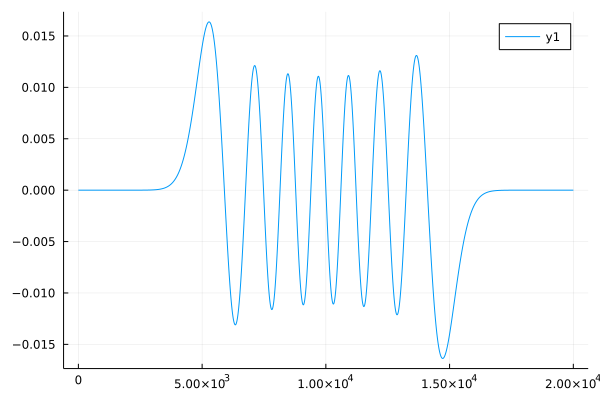

In [64]:
plot(ψ)